In [1]:
from __future__ import division, print_function

import argparse
import csv
import glob
import os
import re
import shutil
import tempfile
import unittest
import gspread as gspread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymia
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import (DiceMetric, HausdorffDistanceMetric,
                           SurfaceDistanceMetric)
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import *
from monai.transforms import (AsDiscrete, AsDiscreted, Compose,
                              CropForegroundd, EnsureChannelFirstd, LoadImage,
                              LoadImaged, Orientationd, RandCropByPosNegLabeld,
                              Resized, ScaleIntensityRanged, Spacingd)
from monai.utils import first, set_determinism
from torch.utils import benchmark
from torch.utils.cpp_extension import load

# import warp as wp



data_dir = "/data/OrganSegmentations"
lltm_cuda = load('lltm_cuda', ['lltm_cuda.cpp', 'lltm_cuda_kernel.cu'], verbose=True)
#help(lltm_cuda)
device = torch.device("cuda")

%matplotlib inline


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using /home/sliceruser/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Creating extension directory /home/sliceruser/.cache/torch_extensions/py310_cu118/lltm_cuda...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/sliceruser/.cache/torch_extensions/py310_cu118/lltm_cuda/build.ninja...
Building extension module lltm_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF lltm_cuda.o.d -DTORCH_EXTENSION_NAME=lltm_cuda -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /workspaces/Hausdorff_morphological/lltm_cuda.cpp -o lltm_cuda.o 
In file included from /usr/local/lib/python3.10/dist-packages/torch/include/c10/core/Device.h:5,
                 from /usr/local/lib/python3.10/dist-packages/torch/include/ATen/core/TensorBody.h:11,
                 from /usr/local/lib/python3.10/dist-packages/torch/include/ATen/core/Tensor.h:3,
                 from /usr/local/lib/py

Loading extension module lltm_cuda...


In [2]:
import torchvision.transforms as T
from scipy import ndimage


def dilatatee_inner(arr, smallK):
    """
    binary dilatation that is applied either to all points or just to a subset of the border points
    """
    arr_new=ndimage.binary_dilation(arr,iterations=1)   
   
    if(smallK):
        inds=np.argwhere(np.logical_and(arr_new,np.logical_not(arr)))
        rng = np.random.default_rng()
        rng.shuffle(inds,axis=0)


        k = (inds.shape[0]//3)*2
        inds=inds[0:k,:]    
        arr_new[inds[:,0],inds[:,1],inds[:,2]]=False
    return arr_new

def dilatatee(arr,n_iter, smallK):
    """
    applies dilatatee_inner function n_iter times
    """
    for i in range(n_iter):
        arr=dilatatee_inner(arr, smallK)
    return arr

def execute_single_case():
    """
    get example files from a dataset preprocess them and return full per voxel Hausdorf distance
    """
    set_determinism(seed=0)
    
    #preprocessing
    val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ])

    #choosing files
    images = sorted(
        glob.glob(os.path.join(data_dir, "*.nii.gz")))
    train_images= list(filter(lambda p : "volume" in p, images))   
    train_labels= list(filter(lambda p : "label" in p, images))

    data_dicts = [
        {"image": image_name, "label": label_name}
        for image_name, label_name in zip(train_images, train_labels)
    ]   
    data_dicts= data_dicts[0:1]

    #get dataloader
    check_ds = Dataset(data=data_dicts, transform=val_transforms)
    check_loader = DataLoader(check_ds, batch_size=1)
    for dat in check_loader:   
        ii=1
        jj=4

        sizz = dat['image'].shape        
        labelBoolTensorA =  torch.where( dat['label']==ii, 1, 0).bool()


        labelBoolTensorB=dilatatee(labelBoolTensorA[0,0,:,:,:].detach().cpu().numpy(),20,True)
        labelBoolTensorB=dilatatee(labelBoolTensorB,10,False)
        labelBoolTensorB= torch.tensor(labelBoolTensorB)

        WIDTH,  HEIGHT,  DEPTH= sizz[2], sizz[3],sizz[4]
        res=lltm_cuda.getHausdorffDistance_3Dres(labelBoolTensorA[0,0,:,:,:].to(device) , labelBoolTensorB.to(device),  WIDTH,  HEIGHT,  DEPTH,1.0, torch.ones(1, dtype =bool) )
        res= res.reshape(WIDTH,  HEIGHT,  DEPTH)
        return res,labelBoolTensorA,labelBoolTensorB

In [3]:
res,labelBoolTensorA,labelBoolTensorB=execute_single_case()


monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


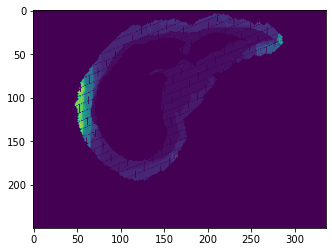

In [4]:
import matplotlib.pyplot as plt
import einops
res_now=res.detach().cpu().numpy()
# res_now = einops.rearrange(res_now,'x y z -> z y x')
res_now= np.rot90(res_now,1)
res_now= np.flip(res_now,1)
x=einops.reduce(res_now, 'x y z -> x', 'sum')
z=einops.reduce(res_now, 'x y z -> z', 'sum')
slice_x= np.argmax(x)
slice_z= np.argmax(z)
to_disp=res_now[:,:,slice_z-40]
# to_disp= np.rot90(to_disp)
# to_disp= np.flip(to_disp,1)

# to_disp= np.rot90(to_disp)

plt.imshow(to_disp)

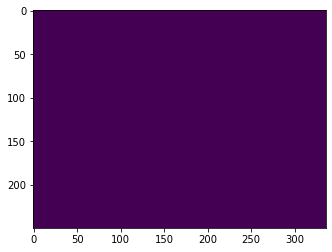

In [5]:
to_disp=labelBoolTensorB.detach().cpu().numpy()[:,:,slice_z-40]
to_disp= np.rot90(to_disp,1)
to_disp= np.flip(to_disp,1)

# to_disp= np.rot90(to_disp)
# to_disp= np.flip(to_disp,1)

# to_disp= np.rot90(to_disp)

plt.imshow(to_disp)

In [6]:
import SimpleITK as sitk

image= sitk.GetImageFromArray(res_now)  
writer = sitk.ImageFileWriter()
writer.SetFileName("/workspaces/Hausdorff_morphological/data/example.nii.gz")
writer.Execute(image)

to_disp=labelBoolTensorA[0,0,:,:,:].detach().cpu().numpy().astype(np.uint8)
to_disp= np.rot90(to_disp,1)
to_disp= np.flip(to_disp,1)


image= sitk.GetImageFromArray(to_disp)  
writer = sitk.ImageFileWriter()
writer.SetFileName("/workspaces/Hausdorff_morphological/data/exampleA.nii.gz")
writer.Execute(image)

to_disp=labelBoolTensorB.detach().cpu().numpy().astype(np.uint8)
to_disp= np.rot90(to_disp,1)
to_disp= np.flip(to_disp,1)


image= sitk.GetImageFromArray(to_disp)  
writer = sitk.ImageFileWriter()
writer.SetFileName("/workspaces/Hausdorff_morphological/data/exampleB.nii.gz")
writer.Execute(image)

